In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import modelbase
from __future__ import annotations
from ast import literal_eval

import json
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from modelbase.ode import Simulator
from matplotlib.colors import TwoSlopeNorm
from modelbase.ode import mca
from modelbase.typing import Figure
from models import get_model

from scipy.integrate import trapezoid
from tqdm.notebook import tqdm
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from modelbase.ode import mca
from matplotlib.colors import TwoSlopeNorm

def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


RES_DIR = Path("results")
with open(RES_DIR / "y0_by_pfd.json", "r") as fp:
    y0s: dict[int, dict[str, float]] = {int(k): v for k, v in json.load(fp).items()}

In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

RXNS = {
    "vPS2": "PS2",
    "vPS1": "PS1",
    "vMehler": "Mehler",
    "vCyc": "CEF",
    "vRuBisCO": "RuBisCO",
    "vFBPase": "FBPase",
    "vDHAR": "DHAR",
    "vRuBisCO": "RuBisCO"
}

In [5]:
co2_vals=[]
pfd_vals=[]
PSII_cc={}
PSII_fc={}
PSI_cc={}
PSI_fc={}
b6f_cc={}
b6f_fc={}
V1_cc={}
V1_fc={}
V9_cc={}
V9_fc={}
for pfd in np.linspace(50,1000,20):
    for co2 in np.linspace(0.005,0.02,20):
        m = get_model()
        s = Simulator(m)
        co2_vals.append(co2)
        pfd_vals.append(pfd)
        s.initialise(y0)
        s.update_parameter("pfd", pfd)
        s.simulate_to_steady_state()
        y0_100 = get_new_y0(s)
        m = get_model()
        m.update_parameter("pfd",pfd)
        m.update_parameter("CO2",co2)
        PSIIcc, PSIIfc = mca.get_response_coefficients(m, "PSIItot" ,y0_100)
        PSII_cc.setdefault(pfd, {})[co2] = PSIIcc
        PSII_fc.setdefault(pfd, {})[co2] = PSIIfc
        PSIcc, PSIfc = mca.get_response_coefficients(m, "PSItot" ,y0_100)
        PSI_cc.setdefault(pfd, {})[co2] = PSIcc
        PSI_fc.setdefault(pfd, {})[co2] = PSIfc
        b6fcc,b6ffc = mca.get_response_coefficients(m, "kCytb6f" ,y0_100)
        b6f_cc.setdefault(pfd, {})[co2] = b6fcc
        b6f_fc.setdefault(pfd, {})[co2] = b6ffc
        V1cc, V1fc = mca.get_response_coefficients(m, "V1_base" ,y0_100)
        V1_cc.setdefault(pfd, {})[co2] = V1cc
        V1_fc.setdefault(pfd, {})[co2] = V1fc
        V9cc, V9fc = mca.get_response_coefficients(m, "V9_base" ,y0_100)
        V9_cc.setdefault(pfd, {})[co2] = V9cc
        V9_fc.setdefault(pfd, {})[co2] = V9fc
PSII_cc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_all_compounds(), dtype=float).T for k, v in PSII_cc.items()})
PSII_fc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_rate_names(), dtype=float).T for k, v in PSII_fc.items()})
PSI_cc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_all_compounds(), dtype=float).T for k, v in PSI_cc.items()})
PSI_fc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_rate_names(), dtype=float).T for k, v in PSI_fc.items()})
b6f_cc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_all_compounds(), dtype=float).T for k, v in b6f_cc.items()})
b6f_fc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_rate_names(), dtype=float).T for k, v in b6f_fc.items()})
V1_cc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_all_compounds(), dtype=float).T for k, v in V1_cc.items()})
V1_fc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_rate_names(), dtype=float).T for k, v in V1_fc.items()})
V9_cc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_all_compounds(), dtype=float).T for k, v in V9_cc.items()})
V9_fc_pd = pd.concat({k: pd.DataFrame(v, index=m.get_rate_names(), dtype=float).T for k, v in V9_fc.items()})

In [6]:
from matplotlib import cm

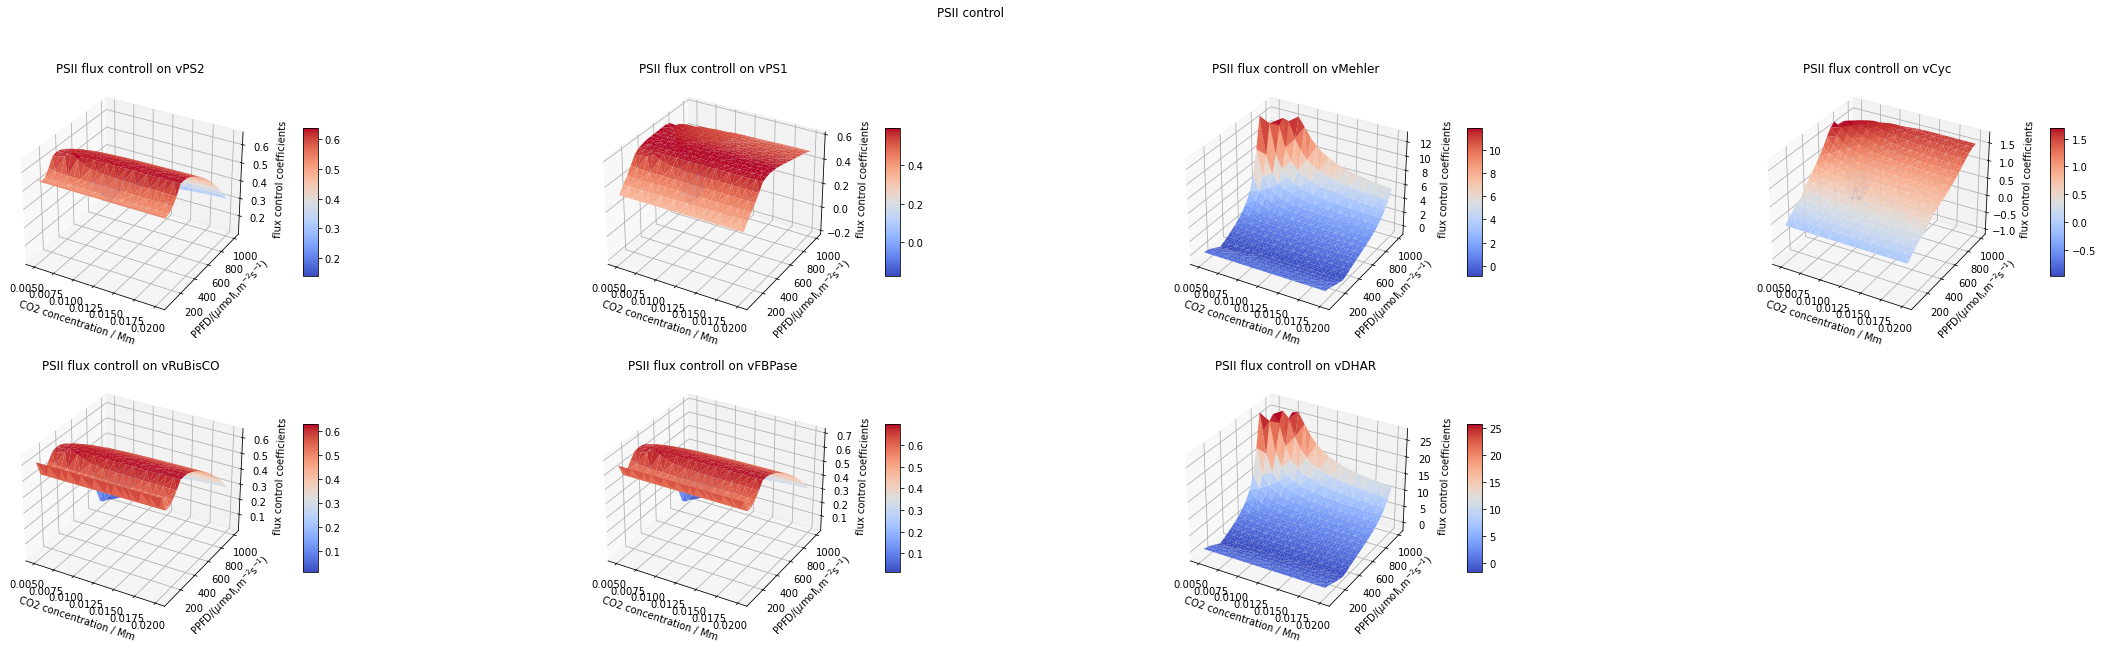

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(40, 10),subplot_kw={"projection": "3d"})
fig.suptitle("PSII control")

for (ax, i) in zip(axs.flatten(), RXNS):
    df = PSII_fc_pd[i]
    surf = ax.plot_trisurf(list(co2_vals), list(pfd_vals), df,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
    ax.set_xlabel("CO2 concentration / Mm")
    ax.set_ylabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax.set_zlabel("flux control coefficients")
    ax.set_title("PSII flux controll on" + " " + i)

fig.delaxes(axs[1,3])
plt.show()



## Figure 1 Photosystem II flux control coefficients over Photosystem II, Photosystem I, the Mehler reaction, cyclic electron flow, RuBisCO, FBPase, and DMAR, depending on different light conditions and CO2 concentrations. The CO2 concentration, depicted on the x-axis, was varied from 0 to 0.02Mm, and the light intensity, depicted on the y-axis, from 50 to 1000 PPFD (µmol m-2s-1). The z-axis resembles the flux control coefficients, though the scale changes depending on the graph.


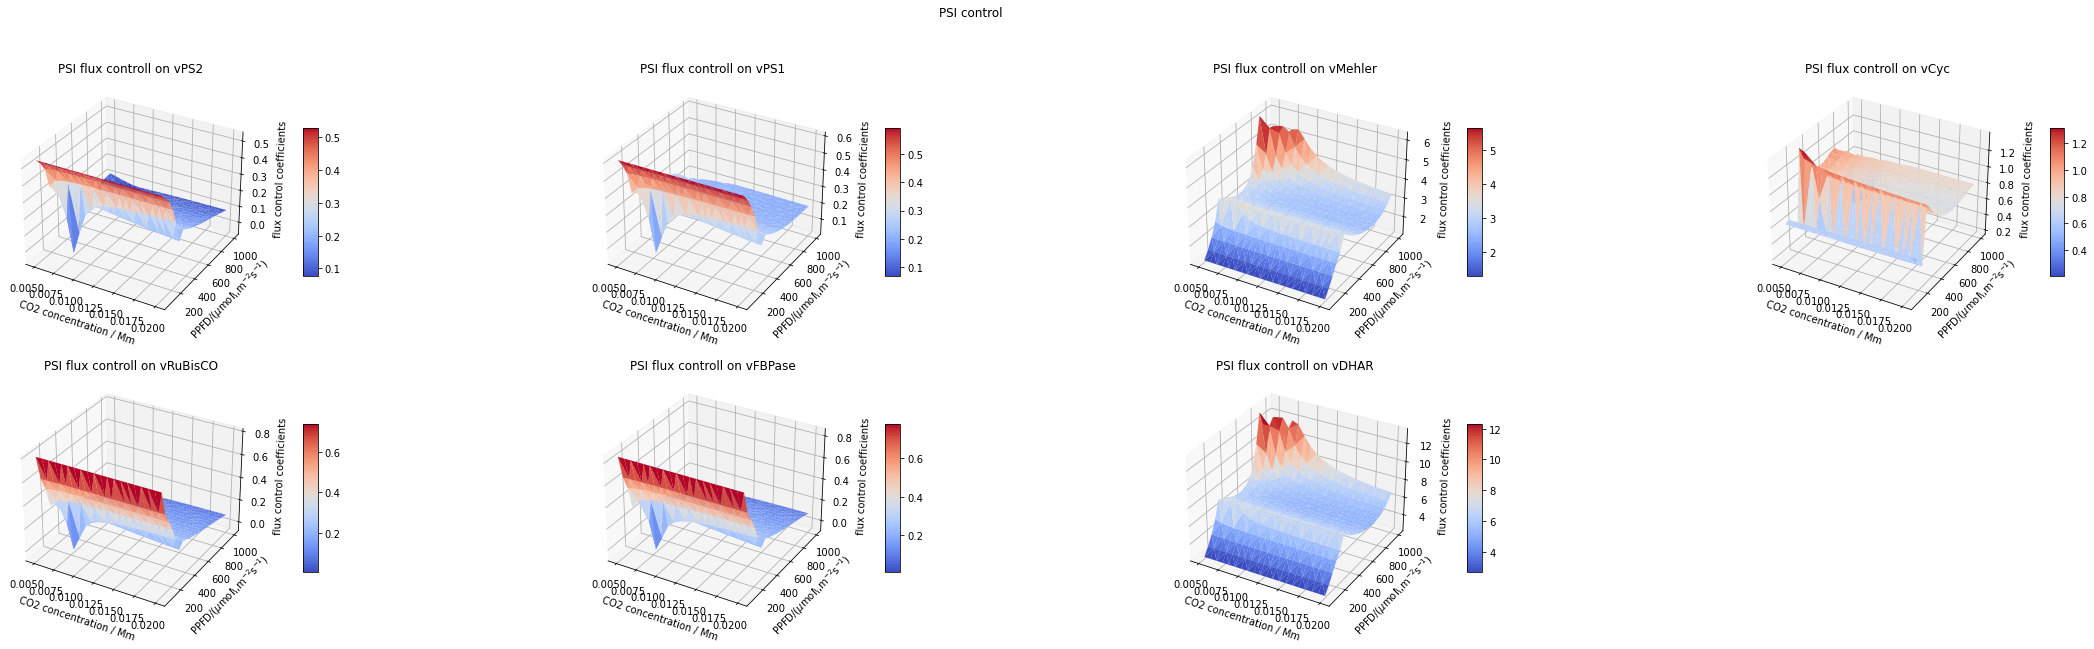

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(40, 10),subplot_kw={"projection": "3d"})
fig.suptitle("PSI control")

for (ax, i) in zip(axs.flatten(), RXNS):
    df = PSI_fc_pd[i]
    surf = ax.plot_trisurf(list(co2_vals), list(pfd_vals), df,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
    ax.set_xlabel("CO2 concentration / Mm")
    ax.set_ylabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax.set_zlabel("flux control coefficients")
    ax.set_title("PSI flux controll on" + " " + i)
fig.delaxes(axs[1,3])
plt.show()

## Figure 2 Photosystem I flux control coefficients over Photosystem II, Photosystem I, the Mehler reaction, cyclic electron flow, RuBisCO, FBPase, and DMAR, depending on different light conditions and CO2 concentrations. The CO2 concentration, depicted on the x-axis, was varied from 0 to 0.02 Mm, and the light intensity, depicted on the y-axis, from 50 to 1000 PPFD (µmol m-2s-1). The z-axis resembles the flux control coefficients, though the scale changes depending on the graph.

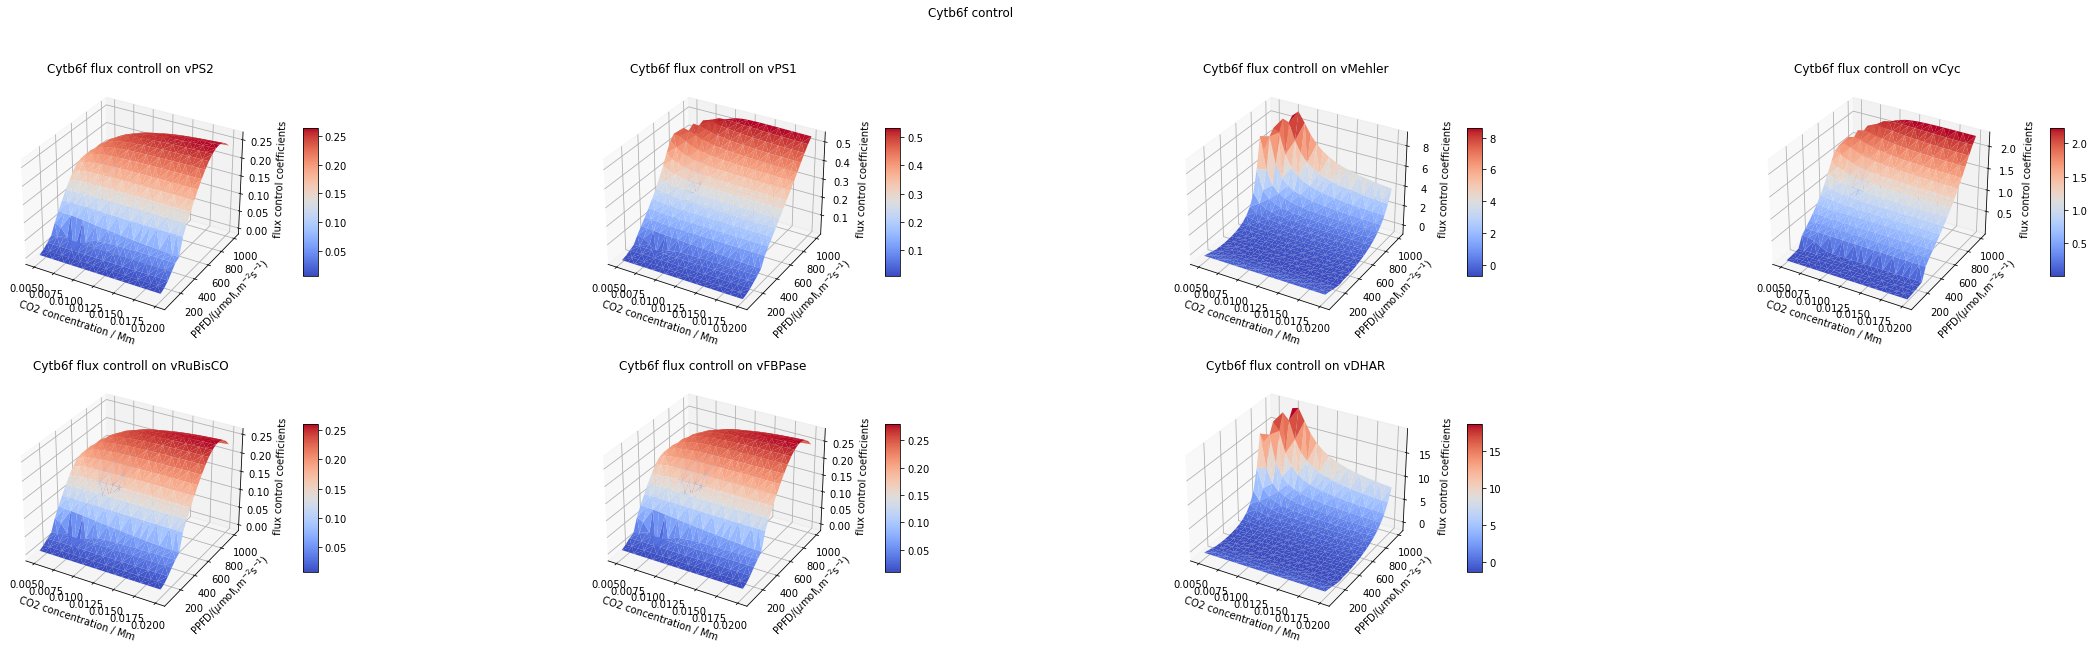

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(40, 10),subplot_kw={"projection": "3d"})
fig.suptitle("Cytb6f control")

for (ax, i) in zip(axs.flatten(), RXNS):
    df = b6f_fc_pd[i]
    surf = ax.plot_trisurf(list(co2_vals), list(pfd_vals), df,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
    ax.set_xlabel("CO2 concentration / Mm")
    ax.set_ylabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax.set_zlabel("flux control coefficients")
    ax.set_title("Cytb6f flux controll on" + " " + i)

fig.delaxes(axs[1,3])
plt.show()

## Figure 3 Cytb6f flux control coefficients over Photosystem II, Photosystem I, the Mehler reaction, cyclic electron flow, RuBisCO, FBPase, and DMAR, depending on different light conditions and CO2 concentrations. The CO2 concentration, depicted on the x-axis, was varied from 0 to 0.02 Mm, and the light intensity, depicted on the y-axis, from 50 to 1000 PPFD (µmol m-2s-1). The z-axis resembles the flux control coefficients, though the scale changes depending on the graph.

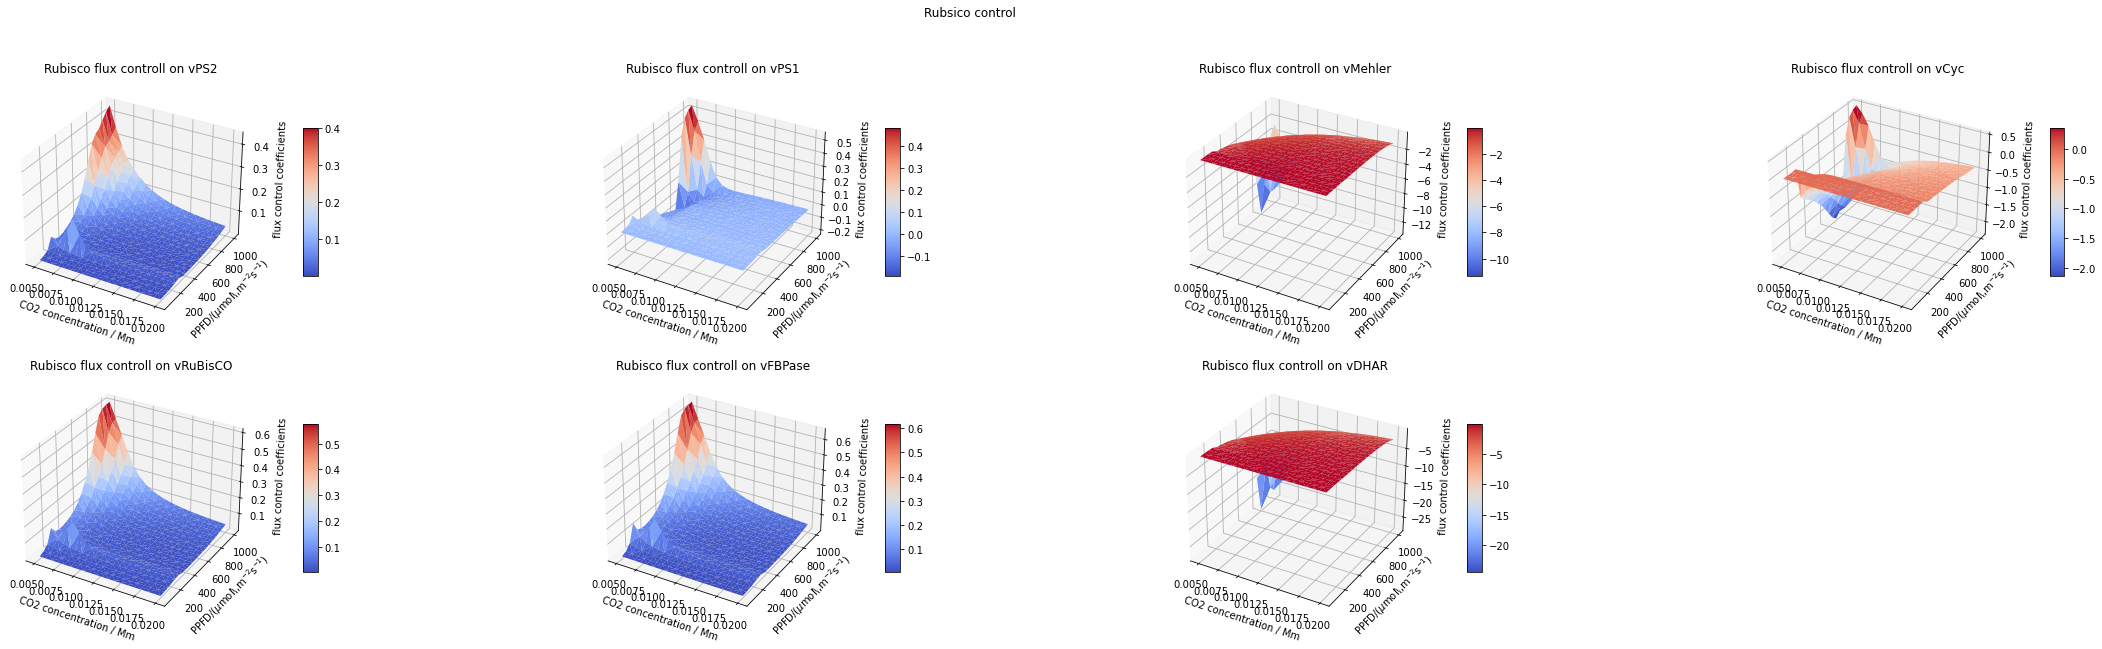

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(40, 10),subplot_kw={"projection": "3d"})
fig.suptitle("Rubsico control")

for (ax, i) in zip(axs.flatten(), RXNS):
    df = V1_fc_pd[i]
    surf = ax.plot_trisurf(list(co2_vals), list(pfd_vals), df,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
    ax.set_xlabel("CO2 concentration / Mm")
    ax.set_ylabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax.set_zlabel("flux control coefficients")
    ax.set_title("Rubisco flux controll on" + " " + i)

fig.delaxes(axs[1,3])
plt.show()

## Figure 4 RuBisCO flux control coefficients over Photosystem II, Photosystem I, the Mehler reaction, cyclic electron flow, RuBisCO, FBPase, and DMAR, depending on different light conditions and CO2 concentrations. The CO2 concentration, depicted on the x-axis, was varied from 0 to 0.02 Mm, and the light intensity, depicted on the y-axis, from 50 to 1000 PPFD (µmol m-2s-1). The z-axis resembles the flux control coefficients, though the scale changes depending on the graph.

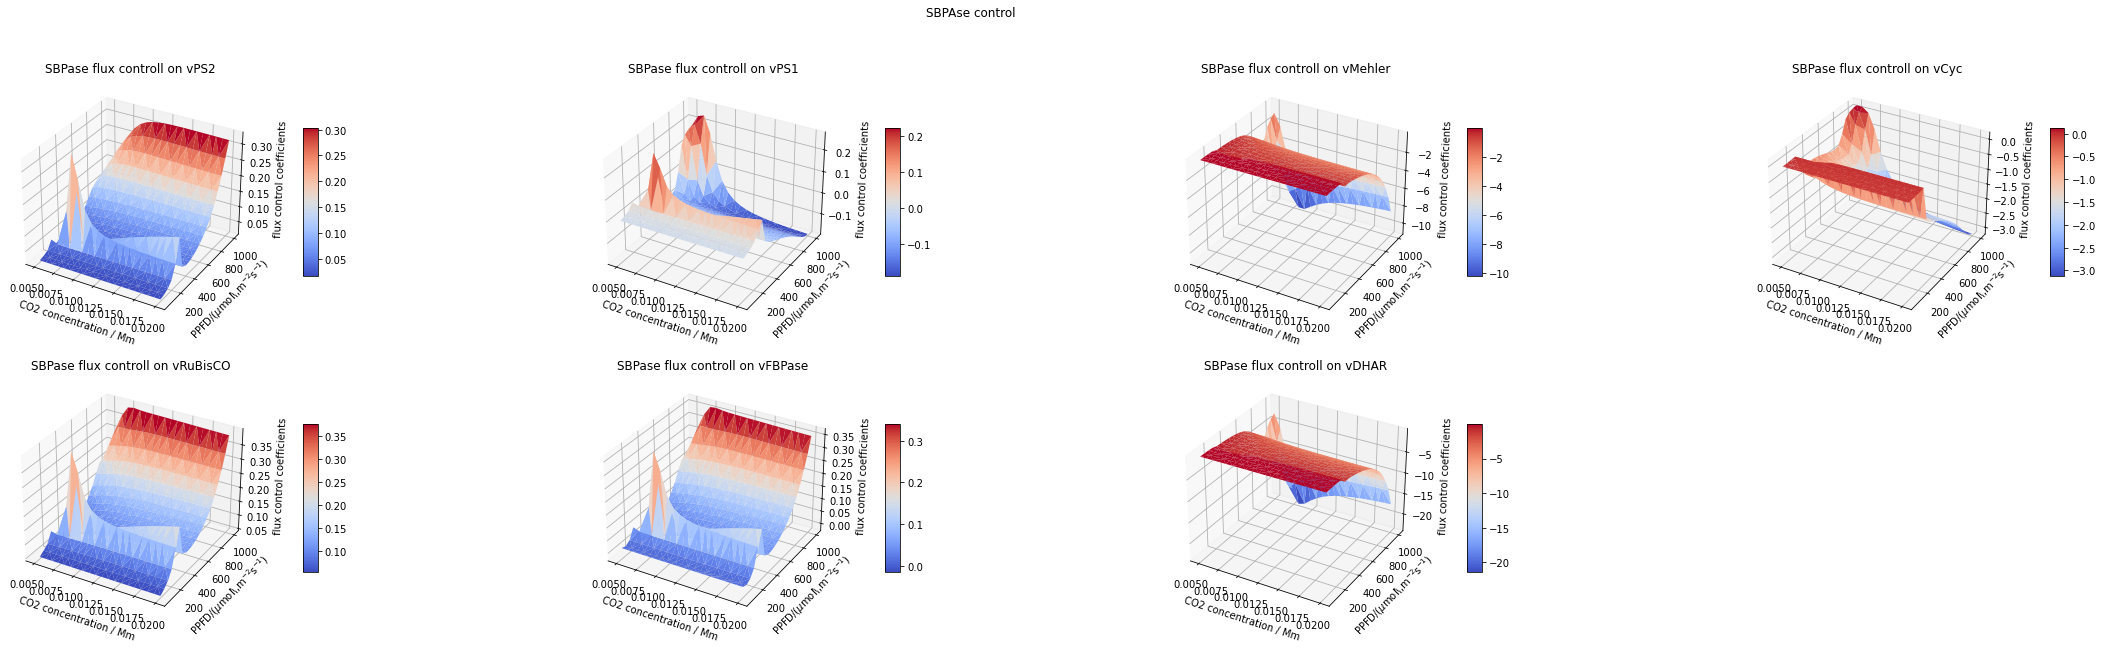

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(40, 10),subplot_kw={"projection": "3d"})
fig.suptitle("SBPAse control")

for (ax, i) in zip(axs.flatten(), RXNS):
    df = V9_fc_pd[i]
    surf = ax.plot_trisurf(list(co2_vals), list(pfd_vals), df,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
    ax.set_xlabel("CO2 concentration / Mm")
    ax.set_ylabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax.set_zlabel("flux control coefficients")
    ax.set_title("SBPase flux controll on" + " " + i)

fig.delaxes(axs[1,3])    
plt.show()

## Figure 5 SBPase flux control coefficients over Photosystem II, Photosystem I, the Mehler reaction, cyclic electron flow, RuBisCO, FBPase, and DMAR, depending on different light conditions and CO2 concentrations. The CO2 concentration, depicted on the x-axis, was varied from 0 to 0.02 Mm, and the light intensity, depicted on the y-axis, from 50 to 1000 PPFD (µmol m-2s-1). The z-axis resembles the flux control coefficients, though the scale changes depending on the graph.